## Inverse dynamics

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

import pandas as pd
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('presentation')
matplotlib.rcParams["xtick.labelsize"] = 16
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig


from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.models.regression import MotionRegression

from src.parameters import df_parameters
from src.substitute_dynamic_symbols import run
from src.models.diff_eq_to_matrix import DiffEqToMatrix
p = df_parameters["symbol"]
import statsmodels.api as sm

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmm_names = global_variables["vmms"]
only_joined = global_variables[
    "only_joined"
]  # (regress/predict with only models from joined runs)S

vmms = {}
for vmm_name in vmm_names:
    vmms[vmm_name] = catalog.load(vmm_name)


2022-03-28 16:49:48,025 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz` (PickleDataSet)...
2022-03-28 16:49:48,197 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_simple` (PickleDataSet)...
2022-03-28 16:49:48,272 - kedro.io.data_catalog - INFO - Loading data from `vmm_martin` (PickleDataSet)...
2022-03-28 16:49:48,322 - kedro.io.data_catalog - INFO - Loading data from `vmm_linear` (PickleDataSet)...
2022-03-28 16:49:48,359 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple` (PickleDataSet)...
2022-03-28 16:49:48,398 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz_expanded` (PickleDataSet)...


In [2]:
%reload_kedro
vmm_name = 'vmm_martins_simple'
vmm = vmms[vmm_name]
data = pd.read_csv('example.csv', index_col=0)
added_masses = catalog.load("added_masses")
model = catalog.load(f"{ vmm_name}.motion_regression.joined.model")
initial_parameters = catalog.load("initial_parameters")
model.parameters=initial_parameters

regression = MotionRegression(
        vmm=vmm,
        data=data,
        added_masses=added_masses,
        prime_system=model.prime_system,
        ship_parameters=model.ship_parameters,
        #exclude_parameters={"Xthrust": 1.0, "Ydelta": 1},
    )

2022-03-28 16:49:48,958 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-03-28 16:49:50,577 - root - INFO - ** Kedro project wPCC_pipeline
2022-03-28 16:49:50,579 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-03-28 16:49:50,589 - root - INFO - Registered line magic `run_viz`
2022-03-28 16:49:50,619 - kedro.io.data_catalog - INFO - Loading data from `added_masses` (YAMLDataSet)...
2022-03-28 16:49:50,621 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple.motion_regression.joined.model` (PickleDataSet)...
2022-03-28 16:49:50,628 - kedro.io.data_catalog - INFO - Loading data from `initial_parameters` (YAMLDataSet)...


e:\dev\wpcc\src\models\regression.py:106: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.exclude_parameters = pd.Series(exclude_parameters)
<string>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
e:\dev\wpcc\src\models\regression.py:470: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series({key: 0 for key in self.connected_parameters_Y.keys()})
e:\dev\wpcc\src\models\regression.py:484: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicit

In [3]:
eq_system

Eq(Matrix([
[-X_{\dot{u}} + m,                    0,                    0],
[               0,     -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])*Matrix([
[\dot{u}],
[\dot{v}],
[\dot{r}]]), Matrix([
[m*r**2*x_G + m*r*v + X_D(u, v, r, delta, thrust)],
[            -m*r*u + Y_D(u, v, r, delta, thrust)],
[        -m*r*u*x_G + N_D(u, v, r, delta, thrust)]]))

In [4]:
solution = sp.solve(eq_system.doit(),X_D,Y_D,N_D, dict=True)[0]

eq_XD = sp.Eq(X_D, solution[X_D])
eq_YD = sp.Eq(Y_D, solution[Y_D])
eq_ND = sp.Eq(N_D, solution[N_D])

display(eq_XD)
display(eq_YD)
display(eq_ND)



Eq(X_D(u, v, r, delta, thrust), -X_{\dot{u}}*\dot{u} + \dot{u}*m - m*r**2*x_G - m*r*v)

Eq(Y_D(u, v, r, delta, thrust), -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u)

Eq(N_D(u, v, r, delta, thrust), I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + \dot{v}*m*x_G + m*r*u*x_G)

In [5]:
display(vmm.X_qs_eq)
display(vmm.Y_qs_eq)
display(vmm.N_qs_eq)


Eq(X_D(u, v, r, delta, thrust), X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{u}*u + X_{vr}*r*v)

Eq(Y_D(u, v, r, delta, thrust), Y_{delta}*delta + Y_{r}*r + Y_{thrustdelta}*delta*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

Eq(N_D(u, v, r, delta, thrust), N_{delta}*delta + N_{r}*r + N_{thrustdelta}*delta*thrust + N_{ur}*r*u + N_{u}*u + N_{v}*v)

In [6]:
subs = [(value, key ) for key,value in p.items()]
subs.append((u1d,'u1d'))
subs.append((v1d,'v1d'))
subs.append((r1d,'r1d'))

eq = eq_XD.subs(subs)
lambda_X_D = sp.lambdify(list(eq.rhs.free_symbols), eq.rhs)

eq = eq_YD.subs(subs)
lambda_Y_D = sp.lambdify(list(eq.rhs.free_symbols), eq.rhs)

eq = eq_ND.subs(subs)
lambda_N_D = sp.lambdify(list(eq.rhs.free_symbols), eq.rhs)

In [7]:
df_captive = data.copy()
df_captive_prime = model.prime_system.prime(df_captive, U=data['U'])

df_captive_prime['fx'] = run(lambda_X_D, 
                             inputs=df_captive_prime, 
                             **model.ship_parameters_prime, 
                             **added_masses)

df_captive_prime['fy'] = run(lambda_Y_D, 
                             inputs=df_captive_prime, 
                             **model.ship_parameters_prime, 
                             **added_masses)

df_captive_prime['mz'] = run(lambda_N_D, 
                             inputs=df_captive_prime, 
                             **model.ship_parameters_prime, 
                             **added_masses)


In [8]:
Y_D_ = sp.symbols('Y_D')
eq = vmm.Y_qs_eq.subs(Y_D,Y_D_)
diff_eq_Y = DiffEqToMatrix(eq, label=Y_D_, base_features=[u,v,r,delta,thrust])

X_Y,y_Y = diff_eq_Y.calculate_features_and_label(data=df_captive_prime, y=df_captive_prime['fy'])

model_Y = sm.OLS(y_Y, X_Y)
result_Y = model_Y.fit()

e:\dev\wpcc\src\models\diff_eq_to_matrix.py:63: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.exclude_parameters = pd.Series(exclude_parameters)


In [9]:
N_D_ = sp.symbols('N_D')
eq = vmm.N_qs_eq.subs(N_D,N_D_)
diff_eq_N = DiffEqToMatrix(eq, label=N_D_, base_features=[u,v,r,delta,thrust])

X_N,y_N = diff_eq_N.calculate_features_and_label(data=df_captive_prime, y=df_captive_prime['mz'])

model_N = sm.OLS(y_N, X_N)
result_N = model_N.fit()

In [10]:
X_D_ = sp.symbols('X_D')
eq = vmm.X_qs_eq.subs(X_D,X_D_)
diff_eq_X = DiffEqToMatrix(eq, label=X_D_, base_features=[u,v,r,delta,thrust], exclude_parameters={'Xthrust':model.parameters['Xthrust']})

X_X,y_X = diff_eq_X.calculate_features_and_label(data=df_captive_prime, y=df_captive_prime['fx'])

model_X = sm.OLS(y_X, X_X)
result_X = model_X.fit()

In [11]:
df_parameters_X = pd.DataFrame(pd.Series({key:value for key,value in model.parameters.items() if key[0]=='X' and value !=0}, name='real'))
df_parameters_X['regression'] = result_X.params
df_parameters_X.dropna(inplace=True)
df_parameters_X.index = p[df_parameters_X.index].apply(lambda x: "$%s$" % str(x).replace('delta',r'\delta'))
df_parameters_X.index.name = ''

df_parameters_Y = pd.DataFrame(pd.Series({key:value for key,value in model.parameters.items() if key[0]=='Y' and value !=0}, name='real'))
df_parameters_Y['regression'] = result_Y.params
df_parameters_Y.dropna(inplace=True)
df_parameters_Y.index = p[df_parameters_Y.index].apply(lambda x: "$%s$" % str(x).replace('delta',r'\delta').replace('thrust','T'))
df_parameters_Y.index.name = ''



df_parameters_N = pd.DataFrame(pd.Series({key:value for key,value in model.parameters.items() if key[0]=='N' and value !=0}, name='real'))
df_parameters_N['regression'] = result_N.params
df_parameters_N.dropna(inplace=True)
df_parameters_N.index = p[df_parameters_N.index].apply(lambda x: "$%s$" % str(x).replace('delta',r'\delta').replace('thrust','T'))
df_parameters_N.index.name = ''


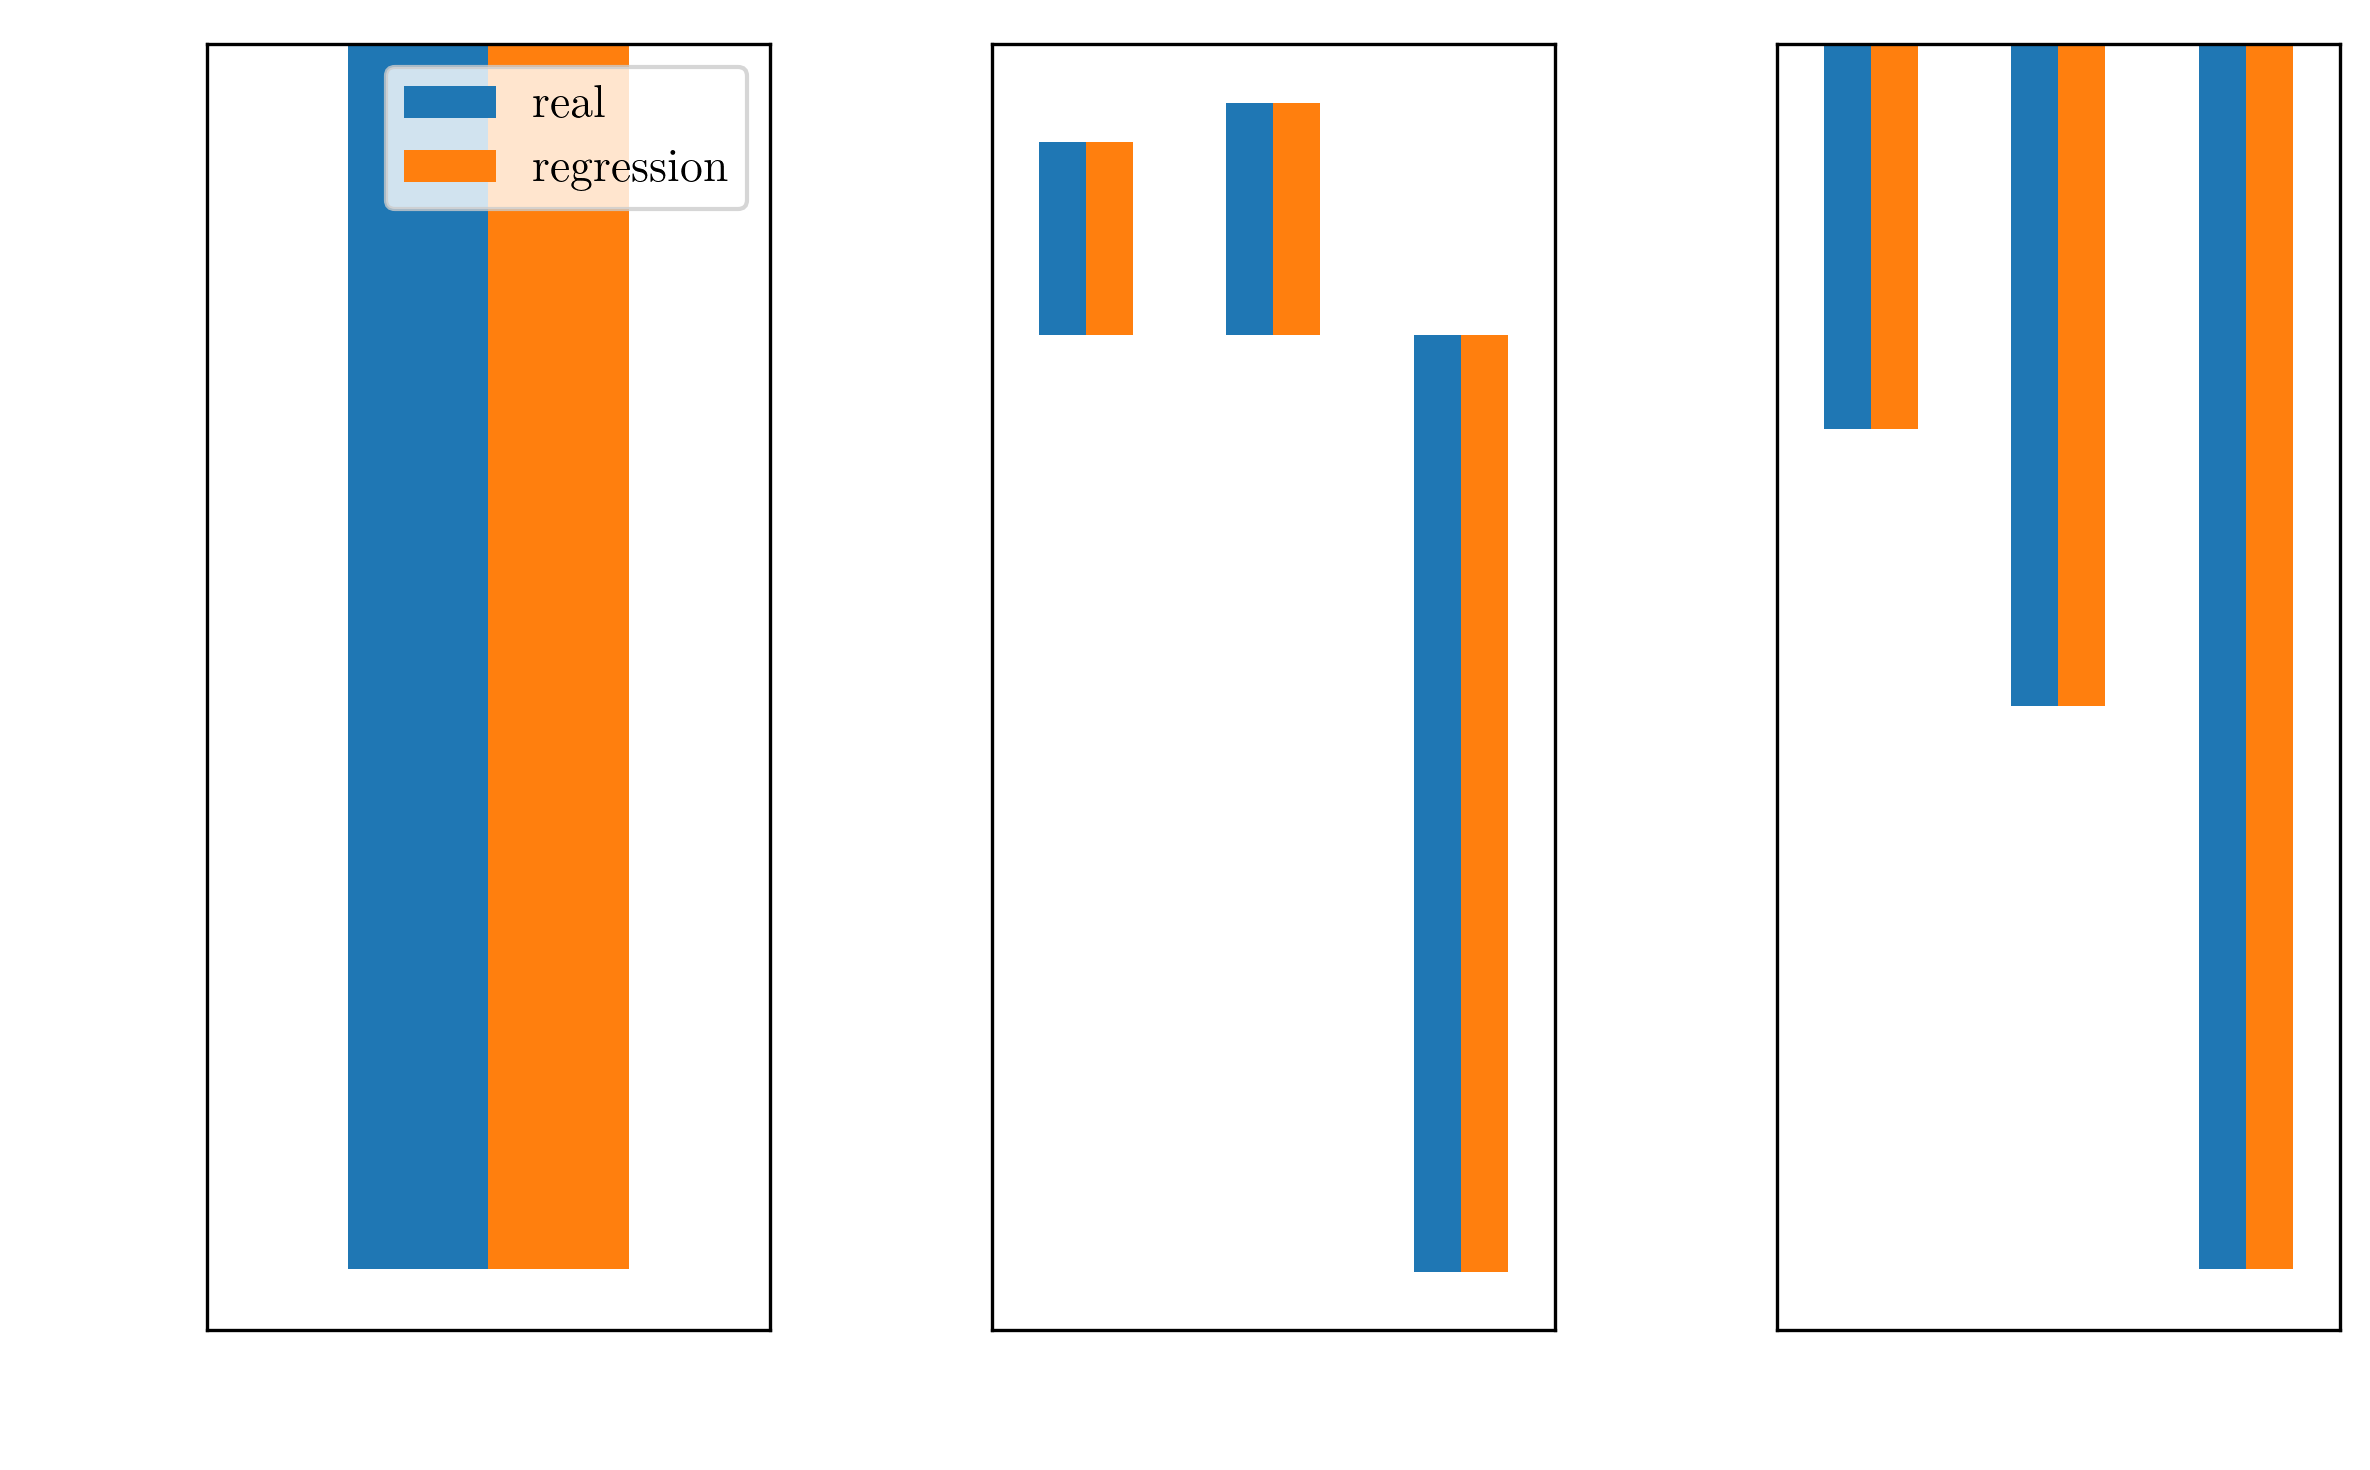

In [12]:
fig,axes=plt.subplots(ncols=3)
ax=axes[0]
df_parameters_X.plot.bar(ax=ax)
ax=axes[1]
df_parameters_Y.plot.bar(ax=ax)
ax.get_legend().set_visible(False)
ax=axes[2]
df_parameters_N.plot.bar(ax=ax)
plt.tight_layout()
ax.get_legend().set_visible(False)
